# Trabalho 4: transformação de Kustaanheimo-Stiefel

Luan Henrique Glasser

Professor Hélio Kuga

03/09/2021

---

## Problema

Use os dados da Lista 01 de computador. Considerando ainda a transformação de tempo $dt = r ds$, mas com as Equações Diferenciais para o sistema “regularizado” via Kustaanheimo-Stiefel (KS), integre a órbita kepleriana por um período orbital, usando um Runge-Kutta 4 (RK4) de passo fixo $ds$ correspondente a $\Delta t = T / 20$. Em seguida implemente um método multi-passo preditor-corretor de ordem 4 (PC4), usando as fórmulas de Adams-Bashfort-Moulton (ABM). Use o RK4 como inicializador do PC.

- Compare os tempos de processamento do Runge-Kutta 4 (RK4) com os do PreditorCorretor 4 (PC4). O que você esperaria? Faça para várias quantidades de passos “np” por período orbital (np = 20, 100, 1000, 10000, etc.),
- Compare estas soluções com as soluções das Listas 01 e 02, convencional, transformado, e estabilizado. Tire e explique suas conclusões.

**Observação**: teremos o mesmo problema de parada no tempo correto, que ocorre quando usamos a transformação de Sundman. Ou seja, notar que o tempo apresentará erros numéricos. Portanto muito provavelmente o tempo final não será o tempo correspondente a 01 período orbital, então usar a solução adotada na Lista 2.

---

## Considerações

Considere a condição inicial (CI) dos vetores posição e velocidade:

* $x$ = 1888980,04103698 $m$
* $y$ = 6652209,67475597 $m$
* $z$ = 902482,883545056 $m$
* $v_x$ = -9585,79511076297 $m/s$
* $v_y$ =  2413,57051166562 $m/s$
* $v_z$ =  2273,50409709003 $m/s$
 
que correspondem a uma órbita com semi-eixo maior $a$ = 34869261 $m$. Use as seguintes constantes onde necessário: $\mu$ = 3,9860064e+14 $m^3/s^2$, raio da Terra $R$ = 6378139 $m$.

---

## Preparo

Esta seção serve para importar bibliotecas e trazer de outros trabalhos as classes de integradores numéricos. Tanto as bibliotecas quanto os integradores são essenciais à solução do problema proposto neste trabalho. 

### Bibliotecas

In [1]:
# Importar bibliotecas.
import numpy as np
import pandas as pd

#%matplotlib notebook
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d    
%matplotlib inline

from math import *

import time

import numpy as np
import seaborn as sns

### Classes de integradores

A seguir, a classe dos integradores Runge-Kutta (RK) será criada.

In [2]:
# Importar classe de integradores Runge-Kutta.
class RungeKutta:
    '''
    Classe RungeKutta
    ---
    Contém Runge-Kuttas de 2a, 3a e 4a ordem.
    '''
        
    # Função do Runge-Kutta 2
    def rk2(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 2a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + h, x + h*k1)
        x = x + (h/2)*(k1 + k2)
        return x    

    # Função do Runge-Kutta 3
    def rk3(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (2/3)*h, x + (2/3)*h*k1)
        k3 = eq(t + (2/3)*h, x + (2/3)*h*k2)
        x = x + (h/4)*(k1 + (3/2)*(k2 + k3))
        return x
    
    # Função do Runge-Kutta 3
    def rk4(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (1/2)*h, x + (1/2)*h*k1)
        k3 = eq(t + (1/2)*h, x + (1/2)*h*k2)
        k4 = eq(t + h, x + h*k3)
        x = x + (h/6)*(k1 + 2*(k2 + k3) + k4)
        return x

    # Função integradora
    def integrador(self, eq, metodo, t0, tf, x0, h):
        '''
        Esta função executa um método integrador sobre uma equação 
        em um intervalo de tempo a partir de um estado inicial.
        ---
        Entradas:
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            metodo - função com o metodo de integração;
            t - tempo atual de integração; 
            x - estado inicial; 
            h - passo de integração.

        '''
        # Listas para armazenar os resultados
        x_arr = []
        t_arr = []

        # Valor inicial de t
        t = t0
        x = x0

        # Armazenar os valores iniciais de t e x
        t_arr.append(t)  
        x_arr.append(x) 

        # Laço para executar os passos de integração
        #for i in np.arange(t0, tf, h):
        while t < tf:

            # Calcular o próximo passo
            x = metodo(eq, t, x, h) 
            
            # Atualizar t
            t += h # calcula o próximo t
            
            # Armazenar os valores de t e x
            x_arr.append(x) 
            t_arr.append(t) 

        return t_arr, x_arr

A próxima classe é a do integrador de ABM.

In [3]:
# Importar classe de integradores Adams-Bashforth-Moulton
class AdamsBashforthMoulton(RungeKutta):
    '''
    Classe que realiza a integração pelo método preditor-corretor de 
    Adams-Bashforth-Moulton.
    '''
    
    def inicializar(self, eq, metodo, t0, x0, h):
        '''
        Função que usa o RK4 para calcular os 4 primeiros pontos da 
        equação diferencial. Serve ao método de Adams-Bashforth-Mouton.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            t_arr = array com os 4 primeiros tempos
            x_arr = array com os 4 primeiros estados
        '''
        t_arr, x_arr = self.integrador(eq = eq, 
                                  metodo = self.rk4, 
                                  t0 = t0, 
                                  tf = t0 + 3*h, 
                                  x0 = x0, 
                                  h = h) # execução com o RK4
        # Armazernar resultados iniciais na classe
        #self.t_arr = t_arr
        #self.x_arr = x_arr
        return t_arr, x_arr
    
    def preditor(self, eq, T, X, F, h):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            xp = estado previsto
        '''
        n = 3
        
        # Previsão
        xp = X[n] + (h/24)*(55*F[n] - 59*F[n - 1] + 37*F[n - 2] - 9*F[n - 3])
         
        return xp

    def corretor(self, eq, T, X, F, h, xp):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
            xp = estado previsto
        Retorna:
            xc = estado corrigido
        '''
        n = 3
        t_prox = T[n] + h
        
        # Calcular o próximo valor da equação diferencial
        f4 = eq(t_prox, xp)
        
        # Corrigir
        xc = X[n] + (h/24)*(9*f4 + 19*F[n] - 5*F[n - 1]+ F[n - 2])
        
        return xc, f4
    
    def configurar_iteracao(self, t_arr, x_arr, f_arr, n):
        '''
        Função para configurar iteração para a predição-correção.
        ---
        Entrada:
            t_arr = array de tempo
            x_arr = array de estados
            n = passo atual
        '''
        # Preparar vetores para predição e correção
        T = t_arr[n - 4:n]
        X = x_arr[n - 4:n]
        F = f_arr[n - 4:n]

        return T, X, F
    
    def preditor_corretor(self, eq, metodo, t0, tf, x0, h):

        # Criar listas de armazenamento
        x_arr = [] # estado
        t_arr = [] # tempo

        # Inicialização
        t_arr, x_arr = self.inicializar(eq, metodo, t0, x0, h)

        # Iniciar valores das equações diferenciais
        
        f3 = eq(t_arr[3], x_arr[3])
        f2 = eq(t_arr[2], x_arr[2])
        f1 = eq(t_arr[1], x_arr[1])
        f0 = eq(t_arr[0], x_arr[0])
        
        f_arr = [f0, f1, f2, f3]
            
        # Definir iterador e tempo inicial
        n = 4 # estamos no 4o passo de integração
        t = t0 + 3*h # aqui é o quinto tempo de integração

        while t < tf:     

            # Configurar iteração
            T, X, F = self.configurar_iteracao(t_arr, x_arr, f_arr, n)

            # Cálculo do estado previsto
            xp = self.preditor(eq, T, X, F, h)

            # Cálculo do estado corrigido
            xc, f_prox = self.corretor(eq, T, X, F, h, xp)
          
            # Atualizar passo atual e tempo atual
            n += 1
            t += h

            # Atualizar vetores de resultados
            t_arr.append(t)
            x_arr.append(xc)
            f_arr.append(f_prox)

        return t_arr, x_arr    

In [4]:
# Função para cálculo dos elementos keplerianos
def elementos_keplerianos(r, v, mu = 3.9860064e5):
    '''
    Cálculo dos elementos keplerianos a partir do vetor posição r e vetor velocidade v
    Entrada: r (vetor posição, km), v (vetor velocidade, km/s)
    Saída: a (semieixo maior, km), e (excentricidade), i (inclinação, graus), 
           Omega (ascensão reta do nodo ascendente, graus), omega (argumento 
           do perigeu, graus), 
           f (anomalia verdadeira, graus)
    Teste (Algoritmo 5.1 do livro Orbital Mechanics for Engineering Students de
    Curtis (2005)):
        in -> r = np.array([-6045, -3490, 2500])
              v = np.array([-3.457, 6.618, 2.533])
              mu = 3.9860064e5 parâmetro gravitacional da Terra, passível de alteração.
        out -> 
            (8788.095117377658, # a
            0.1712123462844537, # e
            153.2492285182475, # i
            255.27928533439618, # Omega
            20.06831665058256, # omega
            28.445628306614942) # f
    '''

    # Normas dos vetores posição e velocidade
    R = np.linalg.norm(r)
    V = np.linalg.norm(v)

    # Cálculo da velocidade radial
    Vr = np.dot(v, r)/R

    # Cálculo do momento angular específico
    h = np.cross(r, v)

    # Cálculo da norma do momento angular
    h_norm = np.linalg.norm(h)

    # Cálculo da inclinação
    i = acos(h[2]/h_norm)

    # Cálculo do vetor dos nodos
    K = np.array([0, 0, 1])
    N = np.cross(K, h)
    N_norm = np.linalg.norm(N)
    Omega = acos(N[0]/N_norm)
    if N[1] < 0.:
        Omega = 2*pi - Omega
    
    # Cálculo do vetor excentricidade
    e_vet = (1/mu)*((V**2 - mu/R)*r - np.dot(r, v)*v)
    e = np.linalg.norm(e_vet)

    # Cálculo do argumento do perigeu
    omega = acos(np.dot(N, e_vet)/(N_norm*e))
    if e_vet[2] < 0.:
        omega = 2*pi - omega
    
    # Cálculo da anomalia verdadeira
    f = acos(np.dot(e_vet, r)/(e*R))
    if Vr < 0.:
        omega = 2*pi - omega
    
    # Cálculo do semieixo maior
    rp = (h_norm**2/mu)*(1/(1 + e*cos(0.)))
    ra = (h_norm**2/mu)*(1/(1 + e*cos(pi)))
    a = 0.5*(rp + ra)

    return a, e, np.rad2deg(i), np.rad2deg(Omega), np.rad2deg(omega), np.rad2deg(f) 

## Equacionando a solução

No trabalho anterior, a equação diferencial trabalhada foi


\begin{equation}
r'' = \frac{|r'| r'}{|r|} - \left( \frac{|r'|^2}{2 |r|^2}  + U + H \right) r + |r|^2 \left( P - \frac{\partial U}{\partial r} \right).
\end{equation}

Essa equação representa a dinâmica do movimento orbital, estabilizada por um vínculo de energia e transformada de tempo físico para tempo fictício por Sundman. Nela, $r$ é o vetor posição orbital, $U$ é o potencial perturbador, $H$ é o negativo da energia mecânica total e $P$ são perturbações dissipativas. O apóstrofo representa a derivada com relação ao tempo fictício $s$.  

Fica claro que essa equação possui singularidades, observe que se $r$ for zero o modelo deixa de ser consistente. Segundo Kuga (2021), é possível, entretanto, transformar as variáveis dessa equação para que ela se comporte como  um oscilador harmônico. Essa regularização é feita pela matriz de Kustaanheimo-Stiefel (KS) e faz com que as singularidades desapareçam, mas isso não vem sem custo. Isso faz com que a dimensão da variável de estado aumente em 2 e acaba sendo necessário integrar 10 equações diferenciais. 

A variável $u$ tem a seguinte relação com $x$: $x = L(u) u$, em que $x = [x_1, x_2, x_3, 0]^T$ e $u = [u_1, u_2, u_3, u_4]^T$. A variável $L(u)$ é a matriz de KS, que tem a forma:

\begin{equation} 
L(u) =
\begin{bmatrix}
    u_1 & -u_2 & -u_3 & u_4 \\
    u_2 & u_1 & -u_4 & -u_3  \\
    u_3 & u_4 & u_1 & u_2 \\
    u_4 & -u_3 & u_2 & -u_1 
\end{bmatrix}.
\end{equation}

A dinâmica se dá por

\begin{equation}
\begin{split}
r' &= v \\
v' &= -\frac{1}{2} (H + U) u + \frac{u.u}{2} \left( - \frac{1}{2} \frac{\partial U}{\partial u} + L^T(u)P \right),
\end{split}
\end{equation}

que são 8 equações. Além dessas, ainda é necessário integrar

\begin{equation}
\begin{split}
H' &= -2(L^T(u) P u') \\
t' &= r,
\end{split}
\end{equation}

que são as atualizações para a energia mecânica total e para o tempo a cada passo.

Esse modelo dinâmico é montado em código abaixo.

In [5]:
def perturbacoes_dissipativas(t, x):
    return np.array([0., 0., 0., 0.])

In [6]:
def potencial_perturbador(t, x):
    return 0.

In [7]:
def perturbacoes_conservativas(t, x):
    return np.array([0., 0., 0., 0.])

In [8]:
def eq_ks(t, x, mu = 3.9860064e5):
    '''
    Função para a dinâmica com o tempo fictício estabilizada e regularizada
    ---
    Entradas:
        t = tempo físico, não utilizado aqui, mas deixado nos 
            argumentos para não dar erro no integrador
        x = estado (u1, u2, u3, u4, vu1, vu2, vu3, vu4, H, t)
    Retorna:
        dxdt = array com os diferenciais do estado
    '''
    
    # Captando variáveis
    u = x[:4]
    v = x[4:8]
    H = x[8]
    ts = x[9]
    
    # Determinando a matriz de Kustananheimo-Stiefel
    u1, u2, u3, u4 = u
    L = np.array([[u1, -u2, -u3,  u4],
                  [u2,  u1, -u4, -u3], 
                  [u3,  u4,  u1,  u2], 
                  [u4, -u3,  u2, -u1]])
    
    # Influências externas
    P = perturbacoes_dissipativas(t, x)
    U = potencial_perturbador(t, x)
    dUdu = perturbacoes_conservativas(t, x)
    
    # Calculando as normas de u e v
    u_norm = np.linalg.norm(u)
    v_norm = np.dot(u, v)/u_norm
    r_norm = np.dot(u, u)
    
    # Calculando os diferenciais com relação ao tempo fictício
    duds = v
    dvds = -(1/2)*(H + U)*u + (np.dot(u, u)/2)*(-(1/2)*dUdu + np.dot(L.T, P))
    dHds = -2*np.dot(np.dot(L.T, P), v)
    dtds = r_norm
    
    # Montando o diferencial
    dxds = np.array([duds[0], duds[1], duds[2], duds[3],
                     dvds[0], dvds[1], dvds[2], dvds[3],
                     dHds,
                     dtds])
    
    return dxds

## Condições iniciais

Uma vez que a dinâmica é conhecida, é necessário que as condições iniciais (CI) sejam definidas. No tempo físico, as definições são triviais. No tempo fictício, as velocidades devem ser multiplicadas pela norma da posição e o tempo fictício final $s_f$ é calculado por $s_f = 2 \pi \sqrt(a/\mu)$. Para ambos os casos, vem a célula de código abaixo.

In [9]:
# As condições iniciais são estas:
r = np.array([1888.98004103698, 6652.20967475597, 902.482883545056]) # km
v = np.array([-9.58579511076297, 2.41357051166562, 2.27350409709003]) # km/s

In [10]:
# Cálculo dos elementos keplerianos
a, e, i, Omega, omega, f = elementos_keplerianos(r, v)

# Plot dos valores calculados para os elementos orbitais
print('a =', a, 'km')
print('e =', e)
print('i =', i, 'graus')
print('Omega =', Omega, 'graus')
print('omega =', omega, 'graus')
print('f =', f, 'graus')

a = 34869.260999999904 km
e = 0.7999999999999995
i = 15.000000000000018 graus
Omega = 45.0 graus
omega = 329.99999999999994 graus
f = 0.0 graus


In [11]:
# Cálculo do período
mu = 3.9860064e5
T = 2*pi*(a**(3/2)/mu**(1/2))

In [12]:
# Condições iniciais em tempo físico e fictício

# Condições iniciais de tempo e passo
t0 = 0.
tf = T
NP = 20
h = tf/NP

# Condições iniciais de estado em tempo físico
x0 = np.array([r[0], r[1], r[2], v[0], v[1], v[2]])

# Condições iniciais de estado em tempo fictício
r_norm = np.linalg.norm(r)

xs0 =  np.array([r[0], r[1], r[2], v[0]*r_norm, v[1]*r_norm, v[2]*r_norm])
rs0 = xs0[:3]
vs0 = xs0[3:]

# Appendando o 0. do final
rs0 = np.append(rs0, 0.)
vs0 = np.append(vs0, 0.)

# Cálculo do semieixo maior
v_norm = np.linalg.norm(v)  # km/s - magnitude da velocidade inicial
a = mu*r_norm/(2*mu - r_norm*v_norm**2) # km - semieixo maior

# Tempos fictícios iniciais
s0 = 0.
sf = 2*np.pi*np.sqrt(a/mu)
hs = (sf - s0)/NP

As CI para a variável $u$ são dadas pelas seguintes equações, ao se definir arbitrariamente $u_1$:

\begin{equation}
\begin{split}
u_4 &= \sqrt{\frac{1}{2}(x_1 + |r|) - u_1^2} \\
u_2 &= \frac{x_2 u_1 + x_3 u_4}{x_1 + |r|} \\
u_3 &= \frac{x_3 u_1 - x_2 u_4}{x_1 + |r|}.
\end{split}
\end{equation}

O estado é completado pela derivadas de $u$ com relação a $s$, dadas por $u'$:

\begin{equation}
u' = \frac{1}{2 |r|} L^T (u) r'.
\end{equation}



In [13]:
# Determinando os u iniciais
x1 = r[0]
x2 = r[1]
x3 = r[2]

# Análogo de posição para u
u1 = 1.
u4 = np.sqrt((x1 + r_norm)/2 - u1**2)
u2 = (x2*u1 + x3*u4)/(x1 + r_norm)
u3 = (x3*u1 - x2*u4)/(x1 + r_norm)
u = np.array([u1, u2, u3, u4])

# Determinando a matriz de Kustananheimo-Stiefel
L = np.array([[u1, -u2, -u3, u4],
              [u2, u1, -u4, -u3], 
              [u3, u4, u1,   u2], 
              [u4, -u3, u2, -u1]])

# Análogo de velocidade para u
#vu1, vu2, vu3, vu4 = (1/(2*np.dot(u, u)))*np.dot(L.T, vs0)
vu1, vu2, vu3, vu4 = (1/2)*np.linalg.inv(L).dot(vs0)

# Vetor de estado de u
u0_arr = np.array([u1, u2, u3, u4, vu1, vu2, vu3, vu4])

A condição inicial para a energia mecânica total é dada por $H = -\epsilon = \frac{\mu}{2a}$. As variáveis $a$ e $\mu$ são o semieixo maior e o parâmetro gravitacional.

In [14]:
# Condição incicial de energia mecânica total
H0 = np.array([mu/(2*a)])

O vetor de estados inicial é então montado:

In [15]:
# Montando o vetor de estado
X0 = np.concatenate((u0_arr, H0, t0), axis = None)

## Execução

A seguir, a dinâmica programada é integrada com as condições iniciais mostradas acima.

In [16]:
# Integração com o Runge-Kutta.
rk = RungeKutta()

# Marcar tempo
tempo_i = time.time()

# Integrar
ts_rk4, xs_rk4 = rk.integrador(eq = eq_ks,
                               metodo = rk.rk4,
                               t0 = s0,
                               tf = sf,
                               x0 = X0,
                               h = hs)

# Calgular tempo do RK4
tempo_f = time.time()
tempo_rk4 = (tempo_f - tempo_i)

In [17]:
# Integração com o ABM
abm = AdamsBashforthMoulton()

# Marcar tempo
tempo_i = time.time()

# Integrar
ts_abm, xs_abm = abm.preditor_corretor(eq = eq_ks,
                                       metodo = abm.rk4,
                                       t0 = s0,
                                       tf = sf,
                                       x0 = X0,
                                       h = hs)

# Calcular tempo do ABM
tempo_f = time.time()
tempo_abm = (tempo_f - tempo_i)

Uma vez que a integração numérica tiver sido realizada, é necessário recuperar de $u$ para $x$. Isso é feito abaixo, usando das relações anteriores.

In [18]:
def recuperar_estados(X):
    '''
    Função para converter as velocidades de s para t
    ---
    Entradas:
        xs = estados com v em s
    Saídas:
        t = tempo fictício
        x = estados com v em t
    '''
    X = np.array(X)
    
    # Separar estado
    u = X[:, :4]
    vu = X[:, 4:8].copy()
    H = X[:, 8]
    t = X[:, 9]
    
    # Listas para salvar dados
    x_lista = []
    v_lista = []
        
    for i, tt in enumerate(t):
        
        # Recuperando o vetor posição
        u1, u2, u3, u4 = u[i, :]
        L = np.array([[u1, -u2, -u3, u4],
                      [u2, u1, -u4, -u3], 
                      [u3, u4, u1, u2], 
                      [u4, -u3, u2, -u1]])
        x = np.dot(L, u[i, :])
        x_lista.append(x[:3])

        # Recuperando o vetor velocidade
        R = np.linalg.norm(x)
        vs = 2*np.dot(L, vu[i, :])
        v_lista.append(vs[:3]/R)
    
    return t, np.array(x_lista), np.array(v_lista), H

In [19]:
# Recuperar estados de U para X
T_rk4, X_rk4, V_rk4, H_rk4 = recuperar_estados(xs_rk4)
T_abm, X_abm, V_abm, H_abm = recuperar_estados(xs_abm)

Para plotar os resultados, a função abaixo é criada.

In [20]:
def plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita'):
    
    # Functions from @Mateen Ulhaq and @karlo
    def set_axes_equal(ax: plt.Axes):
        """Set 3D plot axes to equal scale.
        Make axes of 3D plot have equal scale so that spheres appear as
        spheres and cubes as cubes.  Required since `ax.axis('equal')`
        and `ax.set_aspect('equal')` don't work on 3D.
        """
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis = 1)
        radius = 0.5*np.max(np.abs(limits[:, 1] - limits[:, 0]))
        _set_axes_radius(ax, origin, radius)

    def _set_axes_radius(ax, origin, radius):
        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])
        
    # Função para plotar a órbita em 3D
    def plotar_orbita(x1, x2, x3, ax, titulo):
        ax.plot(x1, x2, x3, alpha = 1)
        ax.set_title(titulo, fontsize = 16, y = 1.05)
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')
        ax.set_zlabel('Z [km]')
        
    # plot earth
    r_plot = 6378.
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))*r_plot  # np.outer() -> outer vector product
    y = np.outer(np.sin(u), np.sin(v))*r_plot
    z = np.outer(np.ones(np.size(u)), np.cos(v))*r_plot

    # 3D plot
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111, projection = '3d')
    ax.plot_surface(x, y, z, cmap = 'Blues', alpha = 0.5)
    
    max_range = np.array([x1.max() 
                          - x1.min(), x2.max() 
                          - x2.min(), x3.max() - x3.min()]).max()/2.0

    mid_x = (x1.max() + x1.min())*0.5
    mid_y = (x2.max() + x2.min())*0.5
    mid_z = (x3.max() + x3.min())*0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Plotar órbita completa
    ax = plotar_orbita(x1, x2, x3, ax, titulo)
    plt.show()

E aplicada para o RK4 e o ABM.

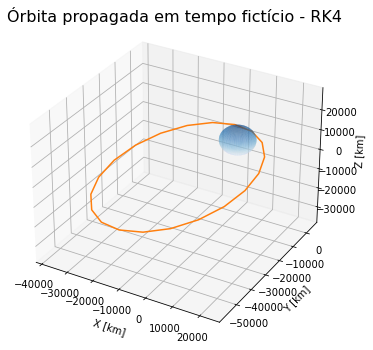

In [21]:
X = np.array(X_rk4)
V = np.array(V_rk4)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
v1 = V[:, 0]
v2 = V[:, 1]
v3 = V[:, 2]
plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita propagada em tempo fictício - RK4')

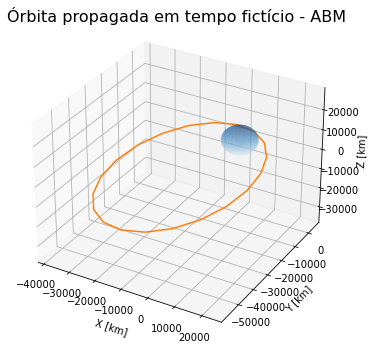

In [22]:
X = np.array(X_abm)
V = np.array(V_abm)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
v1 = V[:, 0]
v2 = V[:, 1]
v3 = V[:, 2]
plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita propagada em tempo fictício - ABM')

## Estudo de tempo dos integradores

Considere que "NP" é o número de passos de integração. A função escrita abaixo gera os resultados obtidos acima para diversos NPs. 

In [23]:
def estudar_tempo(NP):
    # As condições iniciais são estas:
    r = np.array([1888.98004103698, 6652.20967475597, 902.482883545056]) # km
    v = np.array([-9.58579511076297, 2.41357051166562, 2.27350409709003]) # km/s
    # Cálculo dos elementos keplerianos
    a, e, i, Omega, omega, f = elementos_keplerianos(r, v)
    # Cálculo do período
    mu = 3.9860064e5
    T = 2*pi*(a**(3/2)/mu**(1/2))
    # Condições iniciais em tempo físico e fictício
    # Condições iniciais de tempo e passo
    t0 = 0.
    tf = T
    h = tf/NP
    # Condições iniciais de estado em tempo físico
    x0 = np.array([r[0], r[1], r[2], v[0], v[1], v[2]])
    # Condições iniciais de estado em tempo fictício
    r_norm = np.linalg.norm(r)
    xs0 =  np.array([r[0], r[1], r[2], v[0]*r_norm, v[1]*r_norm, v[2]*r_norm])
    rs0 = xs0[:3]
    vs0 = xs0[3:]
    # Appendando o 0. do final
    rs0 = np.append(rs0, 0.)
    vs0 = np.append(vs0, 0.)
    # Cálculo do semieixo maior
    v_norm = np.linalg.norm(v)  # km/s - magnitude da velocidade inicial
    a = mu*r_norm/(2*mu - r_norm*v_norm**2) # km - semieixo maior
    # Tempos fictícios iniciais
    s0 = 0.
    sf = 2*np.pi*np.sqrt(a/mu)
    hs = (sf - s0)/NP
    # Determinando os u iniciais
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    # Análogo de posição para u
    u1 = 1.
    u4 = np.sqrt((x1 + r_norm)/2 - u1**2)
    u2 = (x2*u1 + x3*u4)/(x1 + r_norm)
    u3 = (x3*u1 - x2*u4)/(x1 + r_norm)
    u = np.array([u1, u2, u3, u4])

    # Determinando a matriz de Kustananheimo-Stiefel
    L = np.array([[u1, -u2, -u3, u4],
                  [u2, u1, -u4, -u3], 
                  [u3, u4, u1,   u2], 
                  [u4, -u3, u2, -u1]])
    # Análogo de velocidade para u
    #vu1, vu2, vu3, vu4 = (1/(2*np.dot(u, u)))*np.dot(L.T, vs0)
    vu1, vu2, vu3, vu4 = (1/2)*np.linalg.inv(L).dot(vs0)
    # Vetor de estado de u
    u0_arr = np.array([u1, u2, u3, u4, vu1, vu2, vu3, vu4])
    # Condição incicial de energia mecânica total
    H0 = np.array([mu/(2*a)])
    # Montando o vetor de estado
    X0 = np.concatenate((u0_arr, H0, t0), axis = None)
    # Integração com o Runge-Kutta.
    rk = RungeKutta()
    # Marcar tempo
    tempo_i = time.time()
    # Integrar
    ts_rk4, xs_rk4 = rk.integrador(eq = eq_ks,
                                   metodo = rk.rk4,
                                   t0 = s0,
                                   tf = sf,
                                   x0 = X0,
                                   h = hs)
    # Calgular tempo do RK4
    tempo_f = time.time()
    tempo_rk4 = (tempo_f - tempo_i)
    # Integração com o ABM
    abm = AdamsBashforthMoulton()

    # Marcar tempo
    tempo_i = time.time()

    # Integrar
    ts_abm, xs_abm = abm.preditor_corretor(eq = eq_ks,
                                           metodo = abm.rk4,
                                           t0 = s0,
                                           tf = sf,
                                           x0 = X0,
                                           h = hs)
    # Calcular tempo do ABM
    tempo_f = time.time()
    tempo_abm = (tempo_f - tempo_i)
    
    return np.array([tempo_rk4, tempo_abm])

Abaixo, essa função é rodada para os seguintes números de passos de integração: [20, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000].

In [24]:
# Gerar tempos para análises
NP_lista = [20, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
tempos = []
for NP in NP_lista:
    tempos.append(estudar_tempo(NP))

In [25]:
# Colocar os tempos num array
tempos = np.array(tempos)

In [26]:
# Criar dataframe
df = pd.DataFrame({'tempo_rk4' : tempos[:, 0], 'tempo_abm' : tempos[:, 1]})

In [27]:
# Adicionar os passos de integração ao dataframe
df['NP'] = NP_lista
# Calcular métrica de comparação
df['tempo_abm_vs_rk4'] = (df.tempo_abm - df.tempo_rk4)/df.tempo_rk4
df

,tempo_rk4,tempo_abm,NP,tempo_abm_vs_rk4
0,0.005996,0.003999,20,-0.333068
1,0.011990,0.009994,50,-0.166458
2,0.029002,0.007994,100,-0.724349
3,0.132435,0.046973,500,-0.645310
4,0.235846,0.084951,1000,-0.639801
5,1.412445,0.419289,5000,-0.703147
6,2.567100,0.860707,10000,-0.664716
7,12.812834,4.770828,50000,-0.627652
8,26.911413,8.790169,100000,-0.673366
9,136.680009,42.128692,500000,-0.691771


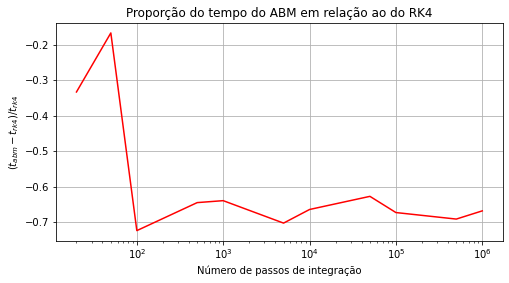

In [28]:
# Plot de comparação
plt.figure(figsize = (8, 4))
plt.plot(df.NP, df.tempo_abm_vs_rk4, color = 'red')
plt.xscale('log')
plt.title('Proporção do tempo do ABM em relação ao do RK4')
plt.ylabel('$(t_{abm} -  t_{rk4})/t_{rk4}$')
plt.xlabel('Número de passos de integração')
plt.grid()

O gráfico acima mostra para cada passo de integração quantas vezes o tempo de integração do ABM é menor que o do RK4. Essa proporção de tempo do ABM com relação ao RK4 será definida pela sigla PAR. O que se nota é que o comportamento médio da PAR diminui, em termos absolutos, se comparado com a PAR para o NP igual a 20. Isso quer dizer o tempo do ABM fica menor que o tempo do RK4, conforme mais passos de integração são utilizados, muito embora a partir de 50.000 passos pareça haver uma de duas possibilidades: uma estabilização em aproximadamente -0,660 ou uma possível tendência de crescimento a partir desse número de passos, possibilidades essas a verificar em oportunidades futuras. Esse gráfico sugere que o desempenho, em termos de tempo, do ABM, é superior ao do RK4, o que faz sentido, já que, ao invés de 4 computações das equações diferenciais a cada passo para o RK4, o ABM faz apenas uma. 

## Comparação com os resultados anteriores

Os resultados do trabalho 1 e 2, somados aos resultados exatos, são mostrados abaixo, para o tempo equivalente a um período orbital.

In [64]:
# Os resultados anteriores foram estes:

# Resultados exatos
exatos = np.array([1888.980040, 6652.209670, 902.482880, 
                   -9.585800, 2.413570, 2.273500, 
                   6973.852195, 10.143061])

# Resultados do RK4 convencional do trabalho 1
t1_rk4_t = np.array([-487327.780000, -133165.057000, 67102.747500, 
                     -7.243491, -2.125082, 0.969778, 
                     509631.314077, 7.610821])

# Resultados do RK4 transformado por Sundman do trabalho 1
t1_rk4_s = np.array([-487327.780000, -133165.057000, 67102.747500, 
                     -7.243491, -2.125082, 0.969778,
                     15083.368507, 6.241124])

# Resultados do RK4 transformado por Sundman estabilizado do trabalho 2
t2_rk4_s_e = np.array([3158.735024, 6206.231892, 577.405242, 
                       -9.078664, 3.362921, 2.357291, 
                       6987.726244, 9.96434])

# Resultados do ABM transformado por Sundman estabilizado do trabalho 2
t2_abm_s_e = np.array([4185.734447, 5899.872932, 324.775575, 
                       -8.558300, 4.061855, 2.391124,
                       7241.156859, 9.770396])

As duas funções a seguir servem para interpolar os resultados deste trabalho e obtê-los no tempo correspondente a um período orbital.

In [65]:
def interpolar(Ts, Xs, parcela, ordem):
    '''
    Função para interpolar cada componente de um vetor de estados
    que contenha posição e velocidade
    ---
    Entradas:
        Xs_rk4 = vetor de estados com nx6 elementos (n x (posição, velocidade))
        parcela = proporção dos dados, contados a partir do final, que será
                    interpolada
        ordem = ordem da interpolação
    '''
    
    # Conversão em array e captação
    Xs = np.array(Xs)
    xs1 = Xs[:, 0]
    xs2 = Xs[:, 1]
    xs3 = Xs[:, 2]
    vxs1 = Xs[:, 3]
    vxs2 = Xs[:, 4]
    vxs3 = Xs[:, 5]
    
    # Indexador
    m = int(parcela*len(Ts))
    
    # Valores para T = 64800 s do RK4
    x_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs1[-m:], deg = ordem)
    y_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs2[-m:], deg = ordem)
    z_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs3[-m:], deg = ordem)
    vx_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs1[-m:], deg = ordem)
    vy_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs2[-m:], deg = ordem)
    vz_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs3[-m:], deg = ordem)
    
    return x_p, y_p, z_p, vx_p, vy_p, vz_p

In [66]:
def resultado_interpolado(x_p, y_p, z_p, vx_p, vy_p, vz_p, w):
    '''
    Esta função calcula o valor de um ajuste de dados interpolados 
    a partir dos coeficientes armazenados em p e do índice no qual
    a interpolação será avaliada w
    '''
    x = x_p(w) 
    y = y_p(w) 
    z = z_p(w) 
    vx = vx_p(w) 
    vy = vy_p(w) 
    vz = vz_p(w) 
    
    return np.array([x, y, z, vx, vy, vz])

Aplicando a interpolação:

In [67]:
# PARA O RK4
# Interpolação para os resultados do RK4 transformado por Sundman, establizado e regularizado
X = np.hstack((X_rk4, V_rk4))
x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4 = interpolar(T_rk4, X, 1/3, 6)

# Valores interpolados para T = 64800 s do RK4
x_rk4 = resultado_interpolado(x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4, T)

In [68]:
# PARA O ABM
# Interpolação para os resultados do RK4 transformado por Sundman, establizado e regularizado
X = np.hstack((X_abm, V_abm))
x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm = interpolar(T_abm, X, 1/3, 6)

# Valores interpolados para T = 64800 s do RK4
x_abm = resultado_interpolado(x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm, T)

In [69]:
# Adicionando o módulo da posição e da velocidade

# RK4
x_rk4 = np.append(x_rk4, np.linalg.norm(x_rk4[:3]))
x_rk4 = np.append(x_rk4, np.linalg.norm(x_rk4[3:6]))

# ABM
x_abm = np.append(x_abm, np.linalg.norm(x_abm[:3]))
x_abm = np.append(x_abm, np.linalg.norm(x_abm[3:6]))

Comparando os resultados obtidos.

In [70]:
# Dataframe para comparação dos resultados deste trabalho
df = pd.DataFrame({'exatos' : exatos,
                   't1_rk4_t' : t1_rk4_t,
                   't1_rk4_s' : t1_rk4_s,
                   't2_rk4_s_e' : t2_rk4_s_e,
                   't2_abm_s_e' : t2_abm_s_e,
                   't4_rk4' : x_rk4,
                   't4_abm' : x_abm,
                   }, index = ['x (km)', 'y (km)', 'z (km)', 
                               '$v_x$ (km/s)', '$v_y$ (km/s)', '$v_z$ (km/s)', 
                               'R (km)', 'V (km/s)'])

Abaixo, a tabela com os resultados dos trabalhos é mostrada. Para referência:

* "exatos" = resultados exatos;
* "t1_rk4_t" = trabalho 1 - integrador RK4 - convencional;
* "t1_rk4_s" = trabalho 1 - integrador RK4 - Sundman;
* "t2_rk4_s_e" = trabalho 2 - integrador RK4 - Sundaman - estabilizado;
* "t2_abm_s_e" = trabalho 2 - integrador ABM - Sundaman - estabilizado;
* "t4_rk4" = trabalho 2 - integrador RK4 - Sundaman - estabilizado - regularizado;
* "t4_abm" = trabalho 2 - integrador ABM - Sundaman - estabilizado - regularizado.

In [71]:
df

,exatos,t1_rk4_t,t1_rk4_s,t2_rk4_s_e,t2_abm_s_e,t4_rk4,t4_abm
x (km),1888.980040,-487327.780000,-487327.780000,3158.735024,4185.734447,1882.563269,1942.769542
y (km),6652.209670,-133165.057000,-133165.057000,6206.231892,5899.872932,6653.843397,6639.482471
z (km),902.482880,67102.747500,67102.747500,577.405242,324.775575,904.008200,889.880051
$v_x$ (km/s),-9.585800,-7.243491,-7.243491,-9.078664,-8.558300,-9.588477,-9.564162
$v_y$ (km/s),2.413570,-2.125082,-2.125082,3.362921,4.061855,2.407801,2.461171
$v_z$ (km/s),2.273500,0.969778,0.969778,2.357291,2.391124,2.272919,2.278424
R (km),6973.852195,509631.314077,15083.368507,6987.726244,7241.156859,6973.873188,6974.881181
V (km/s),10.143061,7.610821,6.241124,9.964340,9.770396,10.144090,10.135175


A seguir, a distância dos resultados com relação aos resultados exatos será calculada.

In [72]:
df['t1_rk4_t_dist'] = np.abs(df['t1_rk4_t'] - df['exatos'])
df['t1_rk4_s_dist'] = np.abs(df['t1_rk4_s'] - df['exatos'])
df['t2_rk4_s_e_dist'] = np.abs(df['t2_rk4_s_e'] - df['exatos'])
df['t2_abm_s_e_dist'] = np.abs(df['t1_rk4_s'] - df['exatos'])
df['t4_abm_dist'] = np.abs(df['t4_abm'] - df['exatos'])
df['t4_rk4_dist'] = np.abs(df['t4_rk4'] - df['exatos'])

In [73]:
# Filtrando apenas os valores de distância no dataframe
df_comparacao = df[['t1_rk4_t_dist', 't1_rk4_s_dist', 't2_abm_s_e_dist',
                    't2_rk4_s_e_dist', 't4_abm_dist', 't4_rk4_dist']]

<AxesSubplot:>

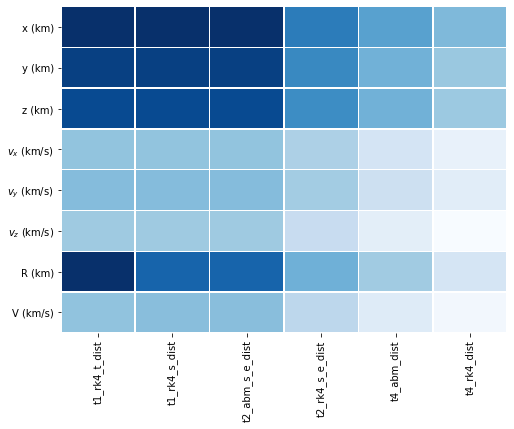

In [74]:
plt.figure(figsize = (8, 6))
sns.heatmap(np.log(df_comparacao), linewidths = 0.5, cmap = "Blues", cbar = False)

Uma visão qualitativa dos resultados pode ser obtida no mapa de calor acima. Cada um dos retângulos do mapa contém o logarítmo do valor de uma célula computada no dataframe. O logarítmo foi utilizado para deixar os resultados numa mesma escala. Quanto mais escura a cor, maior o valor computado na célula, isto é, quanto mais escuro, maior é a distância do resultado em questão para o resultado exato e, portanto, pior o método aplicado para gerar o resultado. 

O que se pode notar é que, de maneira geral, os resultados melhoram da esquerda para a direita. Os métodos são organizados na seguinte ordem, do pior para o melhor: RK4-convencional, RK4-Sundman, ABM-Sundman-estabilizado, RK4-Sundman-estabilizado, ABM-Sundman-estabilizado-regularizado e RK4-Sundman-estabilizado-regularizado. Podemos concluir que o RK4 foi pelo menos tão ou mais exato que o ABM, para todos os métodos testados. 

Mas o ABM contém um algoritmo de predição-correção. Não deveria ser mais exato? O problema é que o ABM implementado neste trabalho é inicializado por um RK4, que é truncado nos termos de 4a ordem. O ABM também é truncado em 4a ordem. Ao se inicializar o ABM com o RK4, erros são inseridos na integração e esses se propagam ao longo do processo, o que degrada seu desempenho em termos de exatidão.

Os valores do mapa de calor, não convertidos em escala logarítmica, podem ser encontrados abaixo, para apreciação.

In [75]:
df_comparacao

,t1_rk4_t_dist,t1_rk4_s_dist,t2_abm_s_e_dist,t2_rk4_s_e_dist,t4_abm_dist,t4_rk4_dist
x (km),489216.760040,489216.760040,489216.760040,1269.754984,53.789502,6.416771
y (km),139817.266670,139817.266670,139817.266670,445.977778,12.727199,1.633727
z (km),66200.264620,66200.264620,66200.264620,325.077638,12.602829,1.525320
$v_x$ (km/s),2.342309,2.342309,2.342309,0.507136,0.021638,0.002677
$v_y$ (km/s),4.538652,4.538652,4.538652,0.949351,0.047601,0.005769
$v_z$ (km/s),1.303722,1.303722,1.303722,0.083791,0.004924,0.000581
R (km),502657.461882,8109.516312,8109.516312,13.874049,1.028986,0.020993
V (km/s),2.532240,3.901937,3.901937,0.178721,0.007886,0.001029


## Referências

KUGA, H. Notas de Aula da Disciplina Satélites Artificiais -  Movimento Orbital. Capítulo 6 - Métodos de Integração de Órbita. Instituto Nacional de Pesquisas Espaciais. 2021.